In [1]:
'''
train_path = '/kaggle/input/tempdata1'

# save all files to kaggle/files/images
path = '/kaggle/working/images'

from zipfile import ZipFile as zipper
with zipper(train_path, 'r') as zipp:
    zipp.extractall(destination)
    
with zipper(test_path, 'r') as zipp:
    zipp.extractall(destination)import os
'''

import torch
import torchvision.models
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
from matplotlib import pyplot as plt 

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

transform = transforms.Compose([
    transforms.Resize([32, 15]),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()    
])

def f(t):
    return torch.tensor([t]).float()

Using cuda device


In [2]:
path = '/kaggle/input/chinafutureohlc/train/5'
ds = datasets.ImageFolder(path, transform = transform, target_transform= f)

print(ds.class_to_idx)

from torch.utils.data import random_split

ds_train, ds_valid = random_split(
    dataset=ds,
    lengths=[.7, .3],
    generator=torch.Generator().manual_seed(0)
)

dl = DataLoader(ds,batch_size = 64,shuffle = True,num_workers=2)

dl_train = DataLoader(ds_train,batch_size = 64,shuffle = True,num_workers=2)
dl_valid = DataLoader(ds_valid,batch_size = 64,shuffle = True,num_workers=2)

{'0': 0, '1': 1}


torch.Size([64, 1, 32, 15])
torch.Size([64, 1])


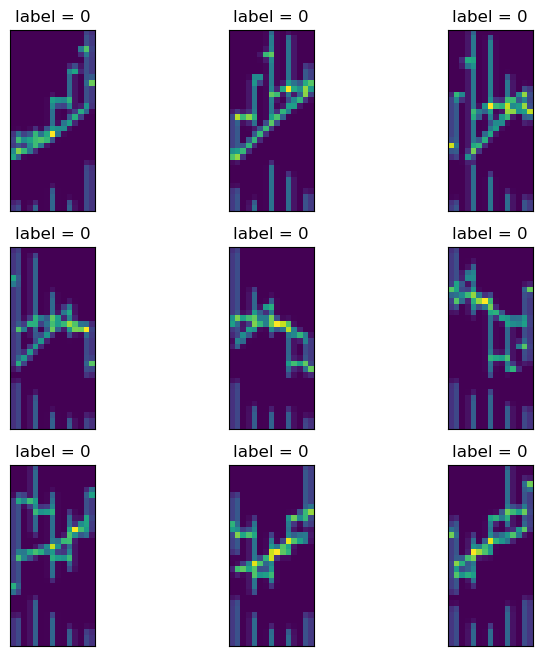

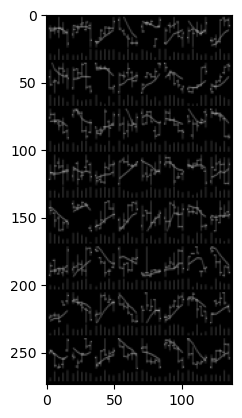

In [3]:
for features,labels in dl:
    print(features.shape)
    print(labels.shape)
    break

plt.figure(figsize=(8,8)) 
for i in range(1,10):
    img,label = ds[i]
    img = img.permute(1,2,0)
    ax=plt.subplot(3,3,i)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label.item())
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

for i, data in enumerate(dl):
    images, labels = data

    img = torchvision.utils.make_grid(images).numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()
 
    break

In [4]:
from torch import nn
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.cnnStack = nn.Sequential(
            nn.Conv2d(1, 64, (5, 3), padding = (2,1)),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d((2,1)),

            nn.Conv2d(64, 128, (5, 3), padding = (2,1)),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d((2,1)),
            
            nn.Flatten(),
            nn.Linear(15360, 2),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        return self.cnnStack(x)

model = NeuralNetwork().to(device)

In [5]:
def two_hot(y):
    label = []
    for i in range(len(y)):
        if y[i]==1:
            label.append([1,0])
        else:
            label.append([0,1])
    return torch.Tensor(label).to(device)
    
loss_fn = nn.CrossEntropyLoss()
def train(dataloader, model, loss_fn, optimizer):
    
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y = two_hot(y)
        pred = model(X)
        #print(pred,y)
        loss = loss_fn(pred, y)
        #print(loss)
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        '''
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        '''
    return loss.item()

In [6]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            y = two_hot(y)
            test_loss += loss_fn(pred, y)
            pred = pred[:,0].ge(0.5)
            y = y[:,0].le(0.5)
            #print(pred,y)
            correct += (pred == y).sum().item()
            
    test_loss /= len(dataloader.dataset)
    #print(f"Average Loss: {test_loss:>7f} Accuracy: {int(correct / len(dataloader.dataset) * 100)}%")
    return test_loss.item(), correct / len(dataloader.dataset)

In [7]:
epochs = 1000
result = []

for t in range(epochs):
    #print(f"Epoch {t+1}\n-------------------------------")
    if(t<30):
        lr = 0.01
    else:
        lr = (epochs-t)/epochs*0.1
    
    optimizer = torch.optim.ASGD(model.parameters(), lr = lr)
    train_loss = train(dl_train, model, loss_fn, optimizer)
    test_loss, curr = test(dl_valid, model, loss_fn)
    print([t, lr, train_loss, test_loss, curr])
    result.append([t, lr, train_loss, test_loss, curr])
    if(t%10 == 0):
        torch.save({
            'epoch': t,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, '/kaggle/working/chkpt'+str(t)+'.pt')
        torch.save(result,'/kaggle/working/result'+str(t)+'.pt')
print("Done!")

[0, 0.01, 0.6941381692886353, 0.01082503143697977, 0.4786197480295414]


[1, 0.01, 0.7036100029945374, 0.010823970660567284, 0.4786197480295414]


[2, 0.01, 0.6879315376281738, 0.010823644697666168, 0.4786197480295414]


[3, 0.01, 0.6925911903381348, 0.010823025368154049, 0.4786197480295414]


[4, 0.01, 0.6912510395050049, 0.010823075659573078, 0.4786197480295414]


[5, 0.01, 0.6718202829360962, 0.010826230980455875, 0.4786197480295414]


[6, 0.01, 0.683782160282135, 0.010822427459061146, 0.4786197480295414]


[7, 0.01, 0.6822718977928162, 0.010822998359799385, 0.4786197480295414]


[8, 0.01, 0.705568253993988, 0.010824430733919144, 0.4786197480295414]


[9, 0.01, 0.7041792869567871, 0.0108222346752882, 0.4788679947868181]


[10, 0.01, 0.6964576244354248, 0.01082232128828764, 0.4796127350586483]


[11, 0.01, 0.6985820531845093, 0.010822266340255737, 0.47899211816545645]


[12, 0.01, 0.6878684163093567, 0.010822172276675701, 0.4800471668838826]


[13, 0.01, 0.6722906827926636, 0.010821696370840073, 0.48010922857320176]


[14, 0.01, 0.7031394839286804, 0.010822172276675701, 0.4800471668838826]


[15, 0.01, 0.6969446539878845, 0.010823319666087627, 0.4788059330974989]


[16, 0.01, 0.6833059787750244, 0.01082222256809473, 0.4788679947868181]


[17, 0.01, 0.6815921068191528, 0.01082184910774231, 0.4801712902625209]


[18, 0.01, 0.6935359239578247, 0.01082158274948597, 0.4801712902625209]


[19, 0.01, 0.6930196285247803, 0.010821700096130371, 0.48010922857320176]


[20, 0.01, 0.6968241333961487, 0.010821597650647163, 0.47936448830137157]


[21, 0.01, 0.7020688056945801, 0.010821620933711529, 0.4806677837770744]


[22, 0.01, 0.6958320140838623, 0.010821996256709099, 0.4796127350586483]


[23, 0.01, 0.6868066787719727, 0.010821363888680935, 0.4796747967479675]


[24, 0.01, 0.6833008527755737, 0.010821533389389515, 0.4804815987091169]


[25, 0.01, 0.694709062576294, 0.010822223499417305, 0.48116427729162786]


[26, 0.01, 0.691414475440979, 0.010821491479873657, 0.4795506733693291]


[27, 0.01, 0.6976262927055359, 0.0108213284984231, 0.48091603053435117]


[28, 0.01, 0.7034718990325928, 0.010821722447872162, 0.4792403649227332]


[29, 0.01, 0.7007251381874084, 0.010821187868714333, 0.47992304350524423]


[30, 0.097, 0.6827826499938965, 0.010826443322002888, 0.4789300564761373]


[31, 0.0969, 0.680199921131134, 0.010822604410350323, 0.4806057220877552]


[32, 0.0968, 0.7029613256454468, 0.01082362700253725, 0.4788059330974989]


[33, 0.09670000000000001, 0.7058686017990112, 0.010828393511474133, 0.47868180971886054]


[34, 0.0966, 0.6968214511871338, 0.0108327092602849, 0.48023335195184014]


[35, 0.0965, 0.687213122844696, 0.010823561809957027, 0.4818469558741389]


[36, 0.0964, 0.6844357252120972, 0.01082420814782381, 0.48283994290324583]


[37, 0.0963, 0.6860267519950867, 0.010826678946614265, 0.48451560851486375]


[38, 0.09620000000000001, 0.6810588240623474, 0.010823742486536503, 0.4806677837770744]


[39, 0.0961, 0.6987690925598145, 0.010826016776263714, 0.4858189039905666]


[40, 0.096, 0.698198676109314, 0.010866290889680386, 0.4959970210389127]


[41, 0.0959, 0.6945766806602478, 0.010830724611878395, 0.4855085955439707]


[42, 0.0958, 0.6856658458709717, 0.010828054510056973, 0.4824675727673307]


[43, 0.09570000000000001, 0.694591760635376, 0.010830684565007687, 0.48346055979643765]


[44, 0.0956, 0.6698346138000488, 0.010837960056960583, 0.4796127350586483]


[45, 0.0955, 0.6945815086364746, 0.010835696943104267, 0.4861912741264817]


[46, 0.0954, 0.686558187007904, 0.010851884260773659, 0.494755787252529]


[47, 0.0953, 0.6889515519142151, 0.010840272530913353, 0.4887978650778874]


[48, 0.0952, 0.7129491567611694, 0.01084329653531313, 0.4832743747284801]


[49, 0.0951, 0.6924014687538147, 0.010842034593224525, 0.4851982870973748]


[50, 0.095, 0.6727672219276428, 0.010864797979593277, 0.49866567367963754]


[51, 0.0949, 0.682408332824707, 0.010855610482394695, 0.4906597157574629]


[52, 0.0948, 0.6827925443649292, 0.010858017019927502, 0.48302612797120337]


[53, 0.0947, 0.6745424270629883, 0.010865841992199421, 0.4869980760876311]


[54, 0.0946, 0.6968291997909546, 0.010869590565562248, 0.48197107925277727]


[55, 0.0945, 0.6665201187133789, 0.0108786690980196, 0.4846397318935021]


[56, 0.0944, 0.704272985458374, 0.010887442156672478, 0.486625705951716]


[57, 0.0943, 0.6765148639678955, 0.010870530270040035, 0.48606715074784335]


[58, 0.0942, 0.6809600591659546, 0.010894383303821087, 0.49202507292248493]


[59, 0.0941, 0.654325008392334, 0.010904435068368912, 0.49636939117482776]


[60, 0.094, 0.6702731251716614, 0.01089104637503624, 0.485260348786694]


[61, 0.0939, 0.6429803967475891, 0.010897330939769745, 0.48470179358282134]


[62, 0.0938, 0.710568904876709, 0.01090004201978445, 0.4851362254080556]


[63, 0.0937, 0.7100231051445007, 0.01089700311422348, 0.48544653385465153]


[64, 0.09360000000000002, 0.6600911617279053, 0.01104335393756628, 0.5071060634270464]


[65, 0.09350000000000001, 0.7089843153953552, 0.010936505161225796, 0.4943213554272947]


[66, 0.09340000000000001, 0.6478749513626099, 0.010970969684422016, 0.48315025134984174]


[67, 0.09330000000000001, 0.6431863307952881, 0.010966626927256584, 0.4840191150003103]


[68, 0.0932, 0.6390035152435303, 0.010948482900857925, 0.4867498293303544]


[69, 0.09310000000000002, 0.6757018566131592, 0.010990970768034458, 0.4860050890585242]


[70, 0.09300000000000001, 0.7005251049995422, 0.011107084341347218, 0.5040029789610874]


[71, 0.09290000000000001, 0.6940888166427612, 0.011029683984816074, 0.4826537578352883]


[72, 0.09280000000000001, 0.6036922931671143, 0.011120766401290894, 0.479860981815925]


[73, 0.0927, 0.6202890276908875, 0.011004630476236343, 0.4923353813690809]


[74, 0.09260000000000002, 0.6966190934181213, 0.011038199998438358, 0.48315025134984174]


[75, 0.09250000000000001, 0.6684407591819763, 0.011028739623725414, 0.48470179358282134]


[76, 0.09240000000000001, 0.658961832523346, 0.01103877555578947, 0.4851362254080556]


[77, 0.09230000000000001, 0.6717501878738403, 0.011185456067323685, 0.5008998944951282]


[78, 0.0922, 0.584500253200531, 0.011049159802496433, 0.4858809656798858]


[79, 0.09210000000000002, 0.7110806703567505, 0.011188262142241001, 0.49823124185440326]


[80, 0.09200000000000001, 0.6574556827545166, 0.011100607924163342, 0.4899770371749519]


[81, 0.09190000000000001, 0.655125617980957, 0.01124271284788847, 0.48147458573822377]


[82, 0.0918, 0.6880218386650085, 0.01126129925251007, 0.48389499162167193]


[83, 0.0917, 0.633727490901947, 0.011452781036496162, 0.5072301868056849]


[84, 0.09160000000000001, 0.6477683186531067, 0.011177534237504005, 0.4836467448643952]


[85, 0.09150000000000001, 0.5803755521774292, 0.01136813871562481, 0.48159870911686214]


[86, 0.09140000000000001, 0.6670949459075928, 0.011160978116095066, 0.4856947806119283]


[87, 0.0913, 0.6559880971908569, 0.01123771257698536, 0.49425929373797556]


[88, 0.0912, 0.6518622636795044, 0.011251460760831833, 0.48979085210699436]


[89, 0.09110000000000001, 0.5717388391494751, 0.011244608089327812, 0.48606715074784335]


[90, 0.09100000000000001, 0.5577992796897888, 0.011252353899180889, 0.4922112579904425]


[91, 0.09090000000000001, 0.545149028301239, 0.0113786980509758, 0.48575684230124744]


[92, 0.0908, 0.5875198245048523, 0.011252669617533684, 0.4887978650778874]


[93, 0.0907, 0.5896808505058289, 0.011266596615314484, 0.4902873456215478]


[94, 0.09060000000000001, 0.6031008362770081, 0.011365949176251888, 0.4846397318935021]


[95, 0.09050000000000001, 0.6273585557937622, 0.01156947948038578, 0.5050580276795135]


[96, 0.09040000000000001, 0.488703191280365, 0.011311785317957401, 0.48749456960218457]


[97, 0.0903, 0.6330755949020386, 0.011349192820489407, 0.4878048780487805]


[98, 0.0902, 0.6145741939544678, 0.011502264067530632, 0.49605908272823185]


[99, 0.09010000000000001, 0.5791752338409424, 0.011398992501199245, 0.49345249177682615]


[100, 0.09000000000000001, 0.6059638857841492, 0.011489405296742916, 0.48854961832061067]


[101, 0.08990000000000001, 0.6067583560943604, 0.011715448461472988, 0.5049959659901943]


[102, 0.0898, 0.6139344573020935, 0.011449551209807396, 0.49581083597095515]


[103, 0.0897, 0.5163654088973999, 0.01142887957394123, 0.4869360143983119]


[104, 0.08960000000000001, 0.556735098361969, 0.011495236307382584, 0.49376280022342206]


[105, 0.08950000000000001, 0.6048523783683777, 0.011533387005329132, 0.4855706572332899]


[106, 0.08940000000000001, 0.647731363773346, 0.011481554247438908, 0.49543846583504003]


[107, 0.0893, 0.5404145121574402, 0.011484370566904545, 0.4876807546701421]


[108, 0.0892, 0.5715242624282837, 0.011600407771766186, 0.4851362254080556]


[109, 0.08910000000000001, 0.5206209421157837, 0.011545729823410511, 0.4904114690001862]


[110, 0.08900000000000001, 0.6418924331665039, 0.011580495163798332, 0.49314218333023024]


[111, 0.0889, 0.5846783518791199, 0.011556586250662804, 0.4959349593495935]


[112, 0.0888, 0.590507447719574, 0.011621726676821709, 0.483584683175076]


[113, 0.0887, 0.5911926627159119, 0.0115452129393816, 0.4886116800099299]


[114, 0.08860000000000001, 0.6236264705657959, 0.011569114401936531, 0.48395705331099115]


[115, 0.08850000000000001, 0.5535574555397034, 0.011922544799745083, 0.48420530006826784]


[116, 0.0884, 0.472716748714447, 0.011718355119228363, 0.49730031651461554]


[117, 0.0883, 0.47534382343292236, 0.011662528850138187, 0.48712219946626945]


[118, 0.0882, 0.48565712571144104, 0.011654647067189217, 0.48948054366039845]


[119, 0.08810000000000001, 0.5564236640930176, 0.011657729744911194, 0.4851982870973748]


[120, 0.08800000000000001, 0.5305863618850708, 0.011720697395503521, 0.49699000806801963]


[121, 0.0879, 0.5141208171844482, 0.011739584617316723, 0.49649351455346613]


[122, 0.0878, 0.5923137068748474, 0.01169875543564558, 0.4904114690001862]


[123, 0.0877, 0.5198521614074707, 0.011681772768497467, 0.4918388878545274]


[124, 0.08760000000000001, 0.5955358743667603, 0.011703074909746647, 0.4937007385341029]


[125, 0.08750000000000001, 0.48611995577812195, 0.011702955700457096, 0.48389499162167193]


[126, 0.0874, 0.46637415885925293, 0.011726719327270985, 0.4906597157574629]


[127, 0.0873, 0.4790845513343811, 0.011739577166736126, 0.48972879041767514]


[128, 0.0872, 0.43021827936172485, 0.011745110154151917, 0.49103208589337805]


[129, 0.08710000000000001, 0.5377981066703796, 0.011784909293055534, 0.4935766151554645]


[130, 0.08700000000000001, 0.5223648548126221, 0.011798246763646603, 0.4948178489418482]


[131, 0.0869, 0.5225467085838318, 0.011876665987074375, 0.48302612797120337]


[132, 0.0868, 0.5063610672950745, 0.011813594028353691, 0.4940110469806988]


[133, 0.0867, 0.5001307129859924, 0.011989603750407696, 0.49798299509712657]


[134, 0.08660000000000001, 0.564041793346405, 0.011741730384528637, 0.48495004034009803]


[135, 0.08650000000000001, 0.44679757952690125, 0.01239038910716772, 0.5107056414075591]


[136, 0.0864, 0.4541991949081421, 0.01186995767056942, 0.49351455346614537]


[137, 0.0863, 0.46743348240852356, 0.01178735587745905, 0.4886116800099299]


[138, 0.0862, 0.4400203824043274, 0.011843410320580006, 0.4855706572332899]


[139, 0.08610000000000001, 0.4913737177848816, 0.011960787698626518, 0.4958728976602743]


[140, 0.08600000000000001, 0.40623024106025696, 0.011864487081766129, 0.49090796251473967]


[141, 0.0859, 0.4897865056991577, 0.01184806413948536, 0.49146651771861233]


[142, 0.0858, 0.44070565700531006, 0.011872446164488792, 0.4926456898156768]


[143, 0.0857, 0.5211750268936157, 0.011920071206986904, 0.4910941475826972]


[144, 0.08560000000000001, 0.4679527282714844, 0.011882257647812366, 0.49022528393222864]


[145, 0.0855, 0.42080458998680115, 0.011864536441862583, 0.48904611183516417]


[146, 0.0854, 0.512678325176239, 0.011934800073504448, 0.49301805995159187]


[147, 0.0853, 0.6128136515617371, 0.011920878663659096, 0.4833984981071185]


[148, 0.0852, 0.4436309337615967, 0.011891070753335953, 0.49301805995159187]


[149, 0.08510000000000001, 0.4453083574771881, 0.011958792805671692, 0.4900390988642711]


[150, 0.085, 0.5647746324539185, 0.012006357312202454, 0.49605908272823185]


[151, 0.0849, 0.5176964402198792, 0.012078248895704746, 0.4993483522621486]


[152, 0.0848, 0.4101497232913971, 0.01190937776118517, 0.4889219884565258]


[153, 0.0847, 0.4858275353908539, 0.011905099265277386, 0.4873704462235462]


[154, 0.08460000000000001, 0.4363499879837036, 0.011913642287254333, 0.4907838391361013]


[155, 0.0845, 0.3739731013774872, 0.012123648077249527, 0.5006516477378514]


[156, 0.0844, 0.3937107026576996, 0.01193426363170147, 0.4910941475826972]


[157, 0.0843, 0.4472677707672119, 0.012039577588438988, 0.4836467448643952]


[158, 0.0842, 0.37933316826820374, 0.011953381821513176, 0.4898529137963135]


[159, 0.08410000000000001, 0.4578670561313629, 0.01205254066735506, 0.48544653385465153]


[160, 0.084, 0.4098788797855377, 0.011936651542782784, 0.4902873456215478]


[161, 0.0839, 0.384421169757843, 0.011940160766243935, 0.4878669397380997]


[162, 0.0838, 0.437324583530426, 0.012059696950018406, 0.4958728976602743]


[163, 0.0837, 0.3308491110801697, 0.011979028582572937, 0.4932663067088686]


[164, 0.08360000000000001, 0.46191978454589844, 0.012067988514900208, 0.49270775150499596]


[165, 0.0835, 0.4692613482475281, 0.011990554630756378, 0.49097002420405883]


[166, 0.0834, 0.355571448802948, 0.01196818146854639, 0.48991497548563273]


[167, 0.0833, 0.38015279173851013, 0.011997934430837631, 0.4914044560292931]


[168, 0.0832, 0.4055977463722229, 0.012125760316848755, 0.49699000806801963]


[169, 0.08310000000000001, 0.44293013215065, 0.01207384467124939, 0.49531434245640166]


[170, 0.083, 0.4439556300640106, 0.012018299661576748, 0.49090796251473967]


[171, 0.0829, 0.4700695276260376, 0.01200034748762846, 0.49301805995159187]


[172, 0.0828, 0.3641214370727539, 0.012088361196219921, 0.4944454788059331]


[173, 0.0827, 0.4587647020816803, 0.012045435607433319, 0.4844535468255446]


[174, 0.0826, 0.40923333168029785, 0.012022532522678375, 0.49419723204865634]


[175, 0.0825, 0.43457332253456116, 0.012189961969852448, 0.4975485632718923]


[176, 0.0824, 0.44706761837005615, 0.0119969192892313, 0.48867374169924904]


[177, 0.0823, 0.3549019396305084, 0.012131663039326668, 0.4995345373301061]


[178, 0.0822, 0.4279829263687134, 0.01200814452022314, 0.49115620927201636]


[179, 0.0821, 0.40963539481163025, 0.012014683336019516, 0.490349407310867]


[180, 0.082, 0.34772989153862, 0.012007836252450943, 0.4906597157574629]


[181, 0.0819, 0.40140461921691895, 0.012019188143312931, 0.4891081735244833]


[182, 0.0818, 0.4057545065879822, 0.012050095945596695, 0.4919009495438466]


[183, 0.0817, 0.37268778681755066, 0.012074355036020279, 0.4925836281263576]


[184, 0.0816, 0.406048059463501, 0.012025545351207256, 0.4904735306895054]


[185, 0.0815, 0.46015363931655884, 0.012061931192874908, 0.49239744305840005]


[186, 0.0814, 0.42453667521476746, 0.012024672701954842, 0.49159064109725065]


[187, 0.0813, 0.34033429622650146, 0.012057890184223652, 0.4912182709613356]


[188, 0.08120000000000001, 0.34665992856025696, 0.012073824182152748, 0.49283187488363434]


[189, 0.0811, 0.3699939250946045, 0.012026694603264332, 0.49059765406814376]


[190, 0.08100000000000002, 0.3382456302642822, 0.012037649750709534, 0.49202507292248493]


[191, 0.08090000000000001, 0.4355778098106384, 0.01202371995896101, 0.49103208589337805]


[192, 0.08080000000000001, 0.3849983215332031, 0.012059489265084267, 0.49090796251473967]


[193, 0.08070000000000001, 0.3928506076335907, 0.012114515528082848, 0.4926456898156768]


[194, 0.0806, 0.3363487720489502, 0.012036692351102829, 0.49053559237882455]


[195, 0.08050000000000002, 0.331253319978714, 0.012050990015268326, 0.4898529137963135]


[196, 0.08040000000000001, 0.3959518373012543, 0.012043065391480923, 0.49103208589337805]


[197, 0.08030000000000001, 0.37928318977355957, 0.012033650651574135, 0.48972879041767514]


[198, 0.08020000000000001, 0.36560356616973877, 0.012071548961102962, 0.4918388878545274]


[199, 0.0801, 0.3308621644973755, 0.012035364285111427, 0.4878048780487805]


[200, 0.08000000000000002, 0.36298102140426636, 0.012047111988067627, 0.4924595047477192]


[201, 0.07990000000000001, 0.4086242914199829, 0.012083591893315315, 0.49314218333023024]


[202, 0.07980000000000001, 0.396598756313324, 0.012030577287077904, 0.4899770371749519]


[203, 0.07970000000000001, 0.4065781235694885, 0.01211569644510746, 0.4941351703593372]


[204, 0.0796, 0.40522149205207825, 0.012059838511049747, 0.49388692360206043]


[205, 0.07950000000000002, 0.44082918763160706, 0.01201369147747755, 0.4861912741264817]


[206, 0.07940000000000001, 0.4551316499710083, 0.012090280652046204, 0.48898405014584495]


[207, 0.07930000000000001, 0.3978610336780548, 0.012022219598293304, 0.48873580338856826]


[208, 0.0792, 0.35923823714256287, 0.01203774381428957, 0.4881772481846956]


[209, 0.0791, 0.38989877700805664, 0.012080561369657516, 0.49103208589337805]


[210, 0.07900000000000001, 0.33559828996658325, 0.012044955976307392, 0.49022528393222864]


[211, 0.07890000000000001, 0.3634464740753174, 0.012023042887449265, 0.48637745919443925]


[212, 0.07880000000000001, 0.3308355212211609, 0.01203339733183384, 0.48823930987401476]


[213, 0.0787, 0.35745948553085327, 0.012048231437802315, 0.4892322969031217]


[214, 0.0786, 0.4158603250980377, 0.012038851156830788, 0.48650158257307763]


[215, 0.07850000000000001, 0.33666911721229553, 0.012029897421598434, 0.4881772481846956]


[216, 0.07840000000000001, 0.36478185653686523, 0.012035291641950607, 0.4895426053497176]


[217, 0.07830000000000001, 0.32590243220329285, 0.012043020687997341, 0.4870601377769503]


[218, 0.0782, 0.41518279910087585, 0.012056941166520119, 0.48867374169924904]


[219, 0.0781, 0.32783597707748413, 0.012048877775669098, 0.4901632222429094]


[220, 0.07800000000000001, 0.34709909558296204, 0.012037751264870167, 0.4901632222429094]


[221, 0.07790000000000001, 0.4243384301662445, 0.01204739697277546, 0.4887978650778874]


[222, 0.07780000000000001, 0.3607025146484375, 0.01205098070204258, 0.48991497548563273]


[223, 0.0777, 0.355203777551651, 0.01205400563776493, 0.4892322969031217]


[224, 0.0776, 0.3661527931690216, 0.012052634730935097, 0.48948054366039845]


[225, 0.07750000000000001, 0.3557048738002777, 0.012045447714626789, 0.4889219884565258]


[226, 0.07740000000000001, 0.32941657304763794, 0.012033580802381039, 0.4880531248060572]


[227, 0.07730000000000001, 0.363539457321167, 0.012066625989973545, 0.49320424501954946]


[228, 0.0772, 0.3249332308769226, 0.012039929628372192, 0.4893564202817601]


[229, 0.0771, 0.35306504368782043, 0.012054214254021645, 0.48929435859244086]


[230, 0.07700000000000001, 0.35394027829170227, 0.012060632929205894, 0.4912182709613356]


[231, 0.07690000000000001, 0.33398398756980896, 0.012058994732797146, 0.4922112579904425]


[232, 0.07680000000000001, 0.32773274183273315, 0.012042136862874031, 0.490349407310867]


[233, 0.0767, 0.35824793577194214, 0.012059643864631653, 0.491714764475889]


[234, 0.0766, 0.3317260146141052, 0.012065920047461987, 0.48979085210699436]


[235, 0.07650000000000001, 0.324791818857193, 0.012025643140077591, 0.4888599267672066]


[236, 0.07640000000000001, 0.3692563474178314, 0.012062236666679382, 0.4906597157574629]


[237, 0.0763, 0.32415807247161865, 0.012041732668876648, 0.4895426053497176]


[238, 0.0762, 0.39054790139198303, 0.0120358532294631, 0.48972879041767514]


[239, 0.0761, 0.3298230767250061, 0.012049892917275429, 0.4898529137963135]


[240, 0.07600000000000001, 0.32882407307624817, 0.012034039944410324, 0.487991063116738]


[241, 0.07590000000000001, 0.32705360651016235, 0.01206381618976593, 0.4901632222429094]


[242, 0.0758, 0.36656439304351807, 0.012037643231451511, 0.4896046670390368]


[243, 0.0757, 0.3574042320251465, 0.012037600390613079, 0.48972879041767514]


[244, 0.0756, 0.3929131329059601, 0.012030539102852345, 0.4884254949419723]


[245, 0.07550000000000001, 0.4026801884174347, 0.01211662869900465, 0.4959349593495935]


[246, 0.07540000000000001, 0.3609631359577179, 0.012045674957334995, 0.48991497548563273]


[247, 0.0753, 0.3583761155605316, 0.012037341482937336, 0.4880531248060572]


[248, 0.0752, 0.32401248812675476, 0.01205452810972929, 0.4915285794079315]


[249, 0.0751, 0.3655392825603485, 0.012035161256790161, 0.4893564202817601]


[250, 0.07500000000000001, 0.3678371012210846, 0.012033402919769287, 0.48972879041767514]


[251, 0.07490000000000001, 0.32781052589416504, 0.012042095884680748, 0.4886116800099299]


[252, 0.0748, 0.35988685488700867, 0.01202571950852871, 0.4887978650778874]


[253, 0.0747, 0.3241300880908966, 0.012042383663356304, 0.4901632222429094]


[254, 0.0746, 0.32601210474967957, 0.012054700404405594, 0.49128033265065474]


[255, 0.0745, 0.3272111713886261, 0.012057904154062271, 0.4919009495438466]


[256, 0.07440000000000001, 0.33086150884628296, 0.012053919956088066, 0.49146651771861233]


[257, 0.0743, 0.3224213421344757, 0.012030571699142456, 0.48904611183516417]


[258, 0.0742, 0.33707305788993835, 0.012089812196791172, 0.49419723204865634]


[259, 0.0741, 0.32764551043510437, 0.012037263251841068, 0.4895426053497176]


[260, 0.074, 0.35893476009368896, 0.012048709206283092, 0.4924595047477192]


[261, 0.07390000000000001, 0.32049959897994995, 0.012030621990561485, 0.48941848197107923]


[262, 0.0738, 0.3561629056930542, 0.012050298973917961, 0.49090796251473967]


[263, 0.0737, 0.3866274952888489, 0.01204268354922533, 0.490349407310867]


[264, 0.0736, 0.3267112672328949, 0.012034599669277668, 0.48904611183516417]


[265, 0.0735, 0.36144697666168213, 0.012050342746078968, 0.49134239433997395]


[266, 0.0734, 0.4824824631214142, 0.012053709477186203, 0.4914044560292931]


[267, 0.0733, 0.32760584354400635, 0.012046020478010178, 0.4918388878545274]


[268, 0.0732, 0.333118736743927, 0.01205058116465807, 0.49010116055359026]


[269, 0.0731, 0.32802870869636536, 0.012035402469336987, 0.49103208589337805]


[270, 0.073, 0.3603716790676117, 0.012047995813190937, 0.491714764475889]


[271, 0.0729, 0.3323548138141632, 0.012028416618704796, 0.48873580338856826]


[272, 0.0728, 0.32466942071914673, 0.012031421065330505, 0.4906597157574629]


[273, 0.0727, 0.3288070559501648, 0.012026566080749035, 0.48873580338856826]


[274, 0.0726, 0.4190068542957306, 0.012040813453495502, 0.4901632222429094]


[275, 0.0725, 0.3253684341907501, 0.012043740600347519, 0.4907217774467821]


[276, 0.0724, 0.38768821954727173, 0.012025286443531513, 0.48929435859244086]


[277, 0.0723, 0.35770276188850403, 0.012020173482596874, 0.489666728728356]


[278, 0.0722, 0.3635510802268982, 0.012034960091114044, 0.48948054366039845]


[279, 0.0721, 0.38923704624176025, 0.012022903189063072, 0.4889219884565258]


[280, 0.072, 0.39073747396469116, 0.012033140286803246, 0.49208713461180414]


[281, 0.0719, 0.3667977750301361, 0.012032579630613327, 0.49053559237882455]


[282, 0.0718, 0.3246905505657196, 0.012033124454319477, 0.49177682616520824]


[283, 0.0717, 0.32432371377944946, 0.012043495662510395, 0.49128033265065474]


[284, 0.0716, 0.3257386088371277, 0.012035802006721497, 0.49022528393222864]


[285, 0.0715, 0.3590063750743866, 0.012036576867103577, 0.49165270278656986]


[286, 0.0714, 0.3887561559677124, 0.012020157650113106, 0.49097002420405883]


[287, 0.0713, 0.3897550404071808, 0.012022950686514378, 0.4902873456215478]


[288, 0.0712, 0.3593614399433136, 0.012027706019580364, 0.48761869298082294]


[289, 0.0711, 0.4183728098869324, 0.012033636681735516, 0.48948054366039845]


[290, 0.071, 0.32452312111854553, 0.012039253488183022, 0.49053559237882455]


[291, 0.0709, 0.33040064573287964, 0.012044140137732029, 0.4907217774467821]


[292, 0.0708, 0.3615913987159729, 0.01202614139765501, 0.4900390988642711]


[293, 0.0707, 0.3543531894683838, 0.012038220651447773, 0.49090796251473967]


[294, 0.0706, 0.3598148226737976, 0.012039252556860447, 0.4915285794079315]


[295, 0.0705, 0.3585013747215271, 0.012031814083456993, 0.48904611183516417]


[296, 0.0704, 0.32932808995246887, 0.012018518522381783, 0.49115620927201636]


[297, 0.0703, 0.3251902461051941, 0.012040608562529087, 0.4900390988642711]


[298, 0.0702, 0.3223339021205902, 0.012023651972413063, 0.49202507292248493]


[299, 0.0701, 0.3233605623245239, 0.012022365815937519, 0.49084590082542046]


[300, 0.06999999999999999, 0.41935819387435913, 0.012021792121231556, 0.49059765406814376]


[301, 0.0699, 0.32404839992523193, 0.012018583714962006, 0.49134239433997395]


[302, 0.0698, 0.39051270484924316, 0.012030105106532574, 0.4904114690001862]


[303, 0.0697, 0.3706471920013428, 0.012037945911288261, 0.491714764475889]


[304, 0.0696, 0.35923075675964355, 0.012033096514642239, 0.49314218333023024]


[305, 0.06949999999999999, 0.3600868582725525, 0.012037218548357487, 0.49010116055359026]


[306, 0.0694, 0.3988130986690521, 0.012075713835656643, 0.4945075404952523]


[307, 0.0693, 0.36097314953804016, 0.012031284160912037, 0.49388692360206043]


[308, 0.0692, 0.35085564851760864, 0.012025686912238598, 0.49059765406814376]


[309, 0.0691, 0.3234840929508209, 0.012031283229589462, 0.490349407310867]


[310, 0.06899999999999999, 0.35530945658683777, 0.01202902290970087, 0.4900390988642711]


[311, 0.0689, 0.3549354076385498, 0.01203757431358099, 0.4906597157574629]


[312, 0.0688, 0.3230796158313751, 0.012036035768687725, 0.4926456898156768]


[313, 0.06870000000000001, 0.32755979895591736, 0.01203091163188219, 0.49053559237882455]


[314, 0.06860000000000001, 0.3871690332889557, 0.012001785449683666, 0.4896046670390368]


[315, 0.0685, 0.3875252604484558, 0.012049410492181778, 0.4902873456215478]


[316, 0.0684, 0.3556253910064697, 0.012019827030599117, 0.49128033265065474]


[317, 0.06830000000000001, 0.3892427086830139, 0.012024051509797573, 0.49090796251473967]


[318, 0.06820000000000001, 0.3551052212715149, 0.01201630663126707, 0.49084590082542046]


[319, 0.06810000000000001, 0.3284890353679657, 0.01204032450914383, 0.4926456898156768]


[320, 0.068, 0.356426864862442, 0.012017661705613136, 0.49128033265065474]


[321, 0.0679, 0.38896438479423523, 0.012013467960059643, 0.48917023521380254]


[322, 0.06780000000000001, 0.38761797547340393, 0.012016111984848976, 0.489666728728356]


[323, 0.06770000000000001, 0.32701563835144043, 0.01202381681650877, 0.4924595047477192]


[324, 0.06760000000000001, 0.3237329423427582, 0.01204012893140316, 0.4898529137963135]


[325, 0.0675, 0.3612106442451477, 0.012009769678115845, 0.49010116055359026]


[326, 0.0674, 0.3896840512752533, 0.012019956484436989, 0.48948054366039845]


[327, 0.06730000000000001, 0.42057090997695923, 0.012009728699922562, 0.48979085210699436]


[328, 0.06720000000000001, 0.42274928092956543, 0.012023678049445152, 0.4922733196797617]


[329, 0.0671, 0.35619863867759705, 0.012021129950881004, 0.49239744305840005]


[330, 0.067, 0.3218556046485901, 0.012017406523227692, 0.4895426053497176]


[331, 0.0669, 0.3596527576446533, 0.01202167198061943, 0.49115620927201636]


[332, 0.06680000000000001, 0.3875925540924072, 0.01201541256159544, 0.4888599267672066]


[333, 0.06670000000000001, 0.4209045171737671, 0.012024873867630959, 0.48972879041767514]


[334, 0.0666, 0.32808172702789307, 0.01203877478837967, 0.493390430087507]


[335, 0.0665, 0.35322973132133484, 0.012021060101687908, 0.4912182709613356]


[336, 0.0664, 0.3550136387348175, 0.012021603994071484, 0.4907838391361013]


[337, 0.06630000000000001, 0.32638758420944214, 0.012019069865345955, 0.49059765406814376]


[338, 0.06620000000000001, 0.354062020778656, 0.012015946209430695, 0.4902873456215478]


[339, 0.0661, 0.3902183473110199, 0.012018095701932907, 0.4907217774467821]


[340, 0.066, 0.331696480512619, 0.012022682465612888, 0.4906597157574629]


[341, 0.0659, 0.3239326477050781, 0.012028936296701431, 0.49134239433997395]


[342, 0.06580000000000001, 0.32545846700668335, 0.01201725285500288, 0.4928939365729535]


[343, 0.06570000000000001, 0.32500579953193665, 0.012012770399451256, 0.4904114690001862]


[344, 0.0656, 0.42324402928352356, 0.012031039223074913, 0.49202507292248493]


[345, 0.0655, 0.387378454208374, 0.012028361670672894, 0.49283187488363434]


[346, 0.0654, 0.3566626310348511, 0.012026640586555004, 0.4915285794079315]


[347, 0.06530000000000001, 0.4212609529495239, 0.012018263339996338, 0.49090796251473967]


[348, 0.06520000000000001, 0.32764187455177307, 0.012021554633975029, 0.49146651771861233]


[349, 0.0651, 0.3617810904979706, 0.012036453001201153, 0.4902873456215478]


[350, 0.065, 0.32729294896125793, 0.012034241110086441, 0.4922733196797617]


[351, 0.0649, 0.32445356249809265, 0.012023160234093666, 0.4912182709613356]


[352, 0.06480000000000001, 0.32350701093673706, 0.012028587982058525, 0.49270775150499596]


[353, 0.06470000000000001, 0.32764899730682373, 0.012012447230517864, 0.48898405014584495]


[354, 0.0646, 0.32876595854759216, 0.012028325349092484, 0.49103208589337805]


[355, 0.0645, 0.3260454833507538, 0.01203364972025156, 0.49239744305840005]


[356, 0.0644, 0.3246080279350281, 0.012027761898934841, 0.4922112579904425]


[357, 0.06430000000000001, 0.3555257320404053, 0.01202315278351307, 0.4918388878545274]


[358, 0.06420000000000001, 0.3582168519496918, 0.012012066319584846, 0.4922112579904425]


[359, 0.0641, 0.35814008116722107, 0.012012404389679432, 0.49314218333023024]


[360, 0.064, 0.3252693712711334, 0.012027427554130554, 0.49196301123316577]


[361, 0.0639, 0.38743436336517334, 0.012016547843813896, 0.48941848197107923]


[362, 0.06380000000000001, 0.3584088683128357, 0.012026824988424778, 0.4929559982622727]


[363, 0.0637, 0.3571435511112213, 0.012023125775158405, 0.4896046670390368]


[364, 0.0636, 0.3571529984474182, 0.012002918869256973, 0.4884254949419723]


[365, 0.0635, 0.32970303297042847, 0.012019728310406208, 0.49084590082542046]


[366, 0.0634, 0.3554498553276062, 0.012043672613799572, 0.4938248619127413]


[367, 0.06330000000000001, 0.35828274488449097, 0.012031606398522854, 0.4904114690001862]


[368, 0.0632, 0.39152786135673523, 0.012017998844385147, 0.49165270278656986]


[369, 0.0631, 0.35926398634910583, 0.012031027115881443, 0.49283187488363434]


[370, 0.063, 0.3556548058986664, 0.012016776017844677, 0.4914044560292931]


[371, 0.0629, 0.3583250939846039, 0.012016220949590206, 0.4907838391361013]


[372, 0.06280000000000001, 0.33103904128074646, 0.012007989920675755, 0.49084590082542046]


[373, 0.0627, 0.4219720661640167, 0.012027974240481853, 0.49239744305840005]


[374, 0.0626, 0.33342674374580383, 0.012024004012346268, 0.4914044560292931]


[375, 0.0625, 0.3224390745162964, 0.012015269137918949, 0.49097002420405883]


[376, 0.062400000000000004, 0.35504260659217834, 0.012003453448414803, 0.4902873456215478]


[377, 0.0623, 0.35479697585105896, 0.012015284970402718, 0.49084590082542046]


[378, 0.062200000000000005, 0.32719916105270386, 0.012008696794509888, 0.48948054366039845]


[379, 0.0621, 0.41945794224739075, 0.012026018463075161, 0.49159064109725065]


[380, 0.062, 0.3621654510498047, 0.012034689076244831, 0.4922733196797617]


[381, 0.061900000000000004, 0.3244730234146118, 0.012012485414743423, 0.49345249177682615]


[382, 0.0618, 0.4205276370048523, 0.0120311314240098, 0.49283187488363434]


[383, 0.061700000000000005, 0.33176857233047485, 0.01203445065766573, 0.49165270278656986]


[384, 0.0616, 0.3877420127391815, 0.012047534808516502, 0.4940110469806988]


[385, 0.0615, 0.355712890625, 0.012014880776405334, 0.49208713461180414]


[386, 0.0614, 0.3883731961250305, 0.012018224224448204, 0.4915285794079315]


[387, 0.0613, 0.3606930673122406, 0.012021580711007118, 0.4914044560292931]


[388, 0.061200000000000004, 0.3222980797290802, 0.01200900413095951, 0.4902873456215478]


[389, 0.0611, 0.3572574555873871, 0.012019313871860504, 0.4906597157574629]


[390, 0.061, 0.3295177221298218, 0.012019339017570019, 0.4918388878545274]


[391, 0.0609, 0.3926435708999634, 0.012012368999421597, 0.48979085210699436]


[392, 0.0608, 0.3892778754234314, 0.012036341242492199, 0.4906597157574629]


[393, 0.060700000000000004, 0.32340937852859497, 0.01202892791479826, 0.4924595047477192]


[394, 0.0606, 0.3872598111629486, 0.012015501968562603, 0.48979085210699436]


[395, 0.0605, 0.3583727180957794, 0.012012597173452377, 0.491714764475889]


[396, 0.0604, 0.35507917404174805, 0.01202709786593914, 0.4932663067088686]


[397, 0.0603, 0.3254081904888153, 0.012018951587378979, 0.491714764475889]


[398, 0.060200000000000004, 0.3941297233104706, 0.012035258114337921, 0.4927698131943152]


[399, 0.0601, 0.4195972979068756, 0.012030797079205513, 0.494073108670018]


[400, 0.06, 0.3240712285041809, 0.012012606486678123, 0.49115620927201636]


[401, 0.0599, 0.356731653213501, 0.012005962431430817, 0.49084590082542046]


[402, 0.0598, 0.36080023646354675, 0.012022962793707848, 0.49208713461180414]


[403, 0.0597, 0.4183826148509979, 0.012013732455670834, 0.491714764475889]


[404, 0.0596, 0.356161504983902, 0.012031310237944126, 0.49301805995159187]


[405, 0.0595, 0.38761088252067566, 0.012030587531626225, 0.49363867684478374]


[406, 0.0594, 0.3618015646934509, 0.01203455962240696, 0.4912182709613356]


[407, 0.0593, 0.3662298917770386, 0.012074119411408901, 0.49500403400980575]


[408, 0.0592, 0.3553966283798218, 0.01202846597880125, 0.4926456898156768]


[409, 0.0591, 0.3281104266643524, 0.012031568214297295, 0.48948054366039845]


[410, 0.059, 0.3583722710609436, 0.012020055204629898, 0.49128033265065474]


[411, 0.0589, 0.32503741979599, 0.012037989683449268, 0.49419723204865634]


[412, 0.0588, 0.324363648891449, 0.012017684988677502, 0.49177682616520824]


[413, 0.0587, 0.32801350951194763, 0.012029556557536125, 0.49177682616520824]


[414, 0.0586, 0.36097612977027893, 0.012019413523375988, 0.49115620927201636]


[415, 0.058499999999999996, 0.3234672546386719, 0.012019534595310688, 0.4910941475826972]


[416, 0.0584, 0.3249438405036926, 0.012007992714643478, 0.4912182709613356]


[417, 0.0583, 0.32697048783302307, 0.012035934254527092, 0.491714764475889]


[418, 0.0582, 0.3221823275089264, 0.012015106156468391, 0.4918388878545274]


[419, 0.0581, 0.4198048412799835, 0.012016987428069115, 0.49097002420405883]


[420, 0.057999999999999996, 0.3865988254547119, 0.012014211155474186, 0.49301805995159187]


[421, 0.0579, 0.3289320170879364, 0.012025107629597187, 0.4927698131943152]


[422, 0.0578, 0.3939424753189087, 0.012014825828373432, 0.4921491963011233]


[423, 0.0577, 0.32417523860931396, 0.012022004462778568, 0.493390430087507]


[424, 0.0576, 0.3569210171699524, 0.012007993645966053, 0.49134239433997395]


[425, 0.057499999999999996, 0.41763752698898315, 0.01202381495386362, 0.49363867684478374]


[426, 0.0574, 0.3229678273200989, 0.012033202685415745, 0.49351455346614537]


[427, 0.0573, 0.3560766279697418, 0.012023690156638622, 0.49208713461180414]


[428, 0.0572, 0.3541596233844757, 0.012019583955407143, 0.4943213554272947]


[429, 0.0571, 0.39090603590011597, 0.012007220648229122, 0.490349407310867]


[430, 0.056999999999999995, 0.3235997259616852, 0.012030402198433876, 0.49283187488363434]


[431, 0.0569, 0.3277517259120941, 0.01200746838003397, 0.4900390988642711]


[432, 0.056799999999999996, 0.3254629075527191, 0.012018726207315922, 0.4925215664370384]


[433, 0.0567, 0.323994904756546, 0.0120156304910779, 0.4922112579904425]


[434, 0.0566, 0.35526350140571594, 0.01202364917844534, 0.49419723204865634]


[435, 0.056499999999999995, 0.35554105043411255, 0.012007301673293114, 0.49134239433997395]


[436, 0.0564, 0.3267171382904053, 0.012017341330647469, 0.49239744305840005]


[437, 0.056299999999999996, 0.32324883341789246, 0.012006872333586216, 0.4919009495438466]


[438, 0.05620000000000001, 0.3897012770175934, 0.012020301073789597, 0.4925836281263576]


[439, 0.05610000000000001, 0.38724616169929504, 0.012011409737169743, 0.49239744305840005]


[440, 0.05600000000000001, 0.3597271144390106, 0.012003058567643166, 0.49022528393222864]


[441, 0.055900000000000005, 0.39155399799346924, 0.012012317776679993, 0.49202507292248493]


[442, 0.05580000000000001, 0.3878261148929596, 0.012014435604214668, 0.4923353813690809]


[443, 0.055700000000000006, 0.3934916853904724, 0.012021191418170929, 0.4930801216409111]


[444, 0.05560000000000001, 0.39006343483924866, 0.012034635990858078, 0.4926456898156768]


[445, 0.05550000000000001, 0.3260999619960785, 0.011996867135167122, 0.4927698131943152]


[446, 0.055400000000000005, 0.3557460308074951, 0.012010536156594753, 0.49084590082542046]


[447, 0.05530000000000001, 0.32510626316070557, 0.012012875638902187, 0.491714764475889]


[448, 0.055200000000000006, 0.3565642535686493, 0.01200222596526146, 0.49010116055359026]


[449, 0.05510000000000001, 0.3271085023880005, 0.012021948583424091, 0.49196301123316577]


[450, 0.05500000000000001, 0.4225272536277771, 0.012009169906377792, 0.48991497548563273]


[451, 0.054900000000000004, 0.3248976469039917, 0.0120048513635993, 0.49239744305840005]


[452, 0.05480000000000001, 0.3249067962169647, 0.012029965408146381, 0.49165270278656986]


[453, 0.054700000000000006, 0.38993778824806213, 0.012012162245810032, 0.49053559237882455]


[454, 0.05460000000000001, 0.3900970220565796, 0.012006676755845547, 0.4914044560292931]


[455, 0.05450000000000001, 0.3545486330986023, 0.012009133584797382, 0.49053559237882455]


[456, 0.054400000000000004, 0.38890042901039124, 0.011997059918940067, 0.4906597157574629]


[457, 0.05430000000000001, 0.36054202914237976, 0.012012965977191925, 0.4922112579904425]


[458, 0.054200000000000005, 0.3216489553451538, 0.012027816846966743, 0.49605908272823185]


[459, 0.05410000000000001, 0.3257782459259033, 0.01201434712857008, 0.493390430087507]


[460, 0.054000000000000006, 0.32092633843421936, 0.012012100778520107, 0.49134239433997395]


[461, 0.0539, 0.39175137877464294, 0.012015215121209621, 0.4925836281263576]


[462, 0.05380000000000001, 0.3910830020904541, 0.012011993676424026, 0.49128033265065474]


[463, 0.053700000000000005, 0.3231600522994995, 0.012018874287605286, 0.4919009495438466]


[464, 0.05360000000000001, 0.3890259265899658, 0.011992459185421467, 0.49010116055359026]


[465, 0.053500000000000006, 0.36022424697875977, 0.012002093717455864, 0.4927698131943152]


[466, 0.0534, 0.36038777232170105, 0.012020738795399666, 0.49208713461180414]


[467, 0.05330000000000001, 0.3586678206920624, 0.012001097202301025, 0.4924595047477192]


[468, 0.053200000000000004, 0.32571345567703247, 0.012009534053504467, 0.4907217774467821]


[469, 0.05310000000000001, 0.3572249412536621, 0.012011024169623852, 0.49208713461180414]


[470, 0.053000000000000005, 0.3606571555137634, 0.012011623941361904, 0.493390430087507]


[471, 0.0529, 0.3875129222869873, 0.012001178227365017, 0.4910941475826972]


[472, 0.05280000000000001, 0.35928040742874146, 0.012006397359073162, 0.49115620927201636]


[473, 0.052700000000000004, 0.3286569118499756, 0.012005571275949478, 0.4925215664370384]


[474, 0.05260000000000001, 0.38775745034217834, 0.012004015035927296, 0.4915285794079315]


[475, 0.052500000000000005, 0.354791522026062, 0.012022559531033039, 0.4922733196797617]


[476, 0.0524, 0.3272543251514435, 0.012019937857985497, 0.4925215664370384]


[477, 0.052300000000000006, 0.3575238287448883, 0.012019621208310127, 0.491714764475889]


[478, 0.0522, 0.33206477761268616, 0.012008854188024998, 0.4912182709613356]


[479, 0.05210000000000001, 0.3308960497379303, 0.01202075369656086, 0.4937007385341029]


[480, 0.052000000000000005, 0.3614046573638916, 0.012005303986370564, 0.4924595047477192]


[481, 0.0519, 0.32908689975738525, 0.01201627030968666, 0.490349407310867]


[482, 0.051800000000000006, 0.32475367188453674, 0.012008015997707844, 0.4925836281263576]


[483, 0.0517, 0.32439032196998596, 0.012018101289868355, 0.4927698131943152]


[484, 0.05160000000000001, 0.42133629322052, 0.012010878883302212, 0.49301805995159187]


[485, 0.051500000000000004, 0.35678714513778687, 0.01200410258024931, 0.4918388878545274]


[486, 0.0514, 0.3239661753177643, 0.01201927475631237, 0.4922112579904425]


[487, 0.051300000000000005, 0.35466423630714417, 0.01201868150383234, 0.4935766151554645]


[488, 0.0512, 0.358004093170166, 0.012017646804451942, 0.49388692360206043]


[489, 0.051100000000000007, 0.32402241230010986, 0.012017096392810345, 0.49270775150499596]


[490, 0.051000000000000004, 0.3568041920661926, 0.012008113786578178, 0.49165270278656986]


[491, 0.0509, 0.32862386107444763, 0.0120234414935112, 0.4925215664370384]


[492, 0.050800000000000005, 0.3263915479183197, 0.012020191177725792, 0.493390430087507]


[493, 0.0507, 0.35403338074684143, 0.012018295004963875, 0.49419723204865634]


[494, 0.050600000000000006, 0.45118698477745056, 0.012017887085676193, 0.49394898529137965]


[495, 0.0505, 0.3869527280330658, 0.012024587951600552, 0.4943213554272947]


[496, 0.0504, 0.32643362879753113, 0.01202233787626028, 0.4933283683981878]


[497, 0.050300000000000004, 0.4182892441749573, 0.012011316604912281, 0.49270775150499596]


[498, 0.0502, 0.32921528816223145, 0.012013182044029236, 0.49202507292248493]


[499, 0.050100000000000006, 0.33877426385879517, 0.01201885286718607, 0.49103208589337805]


[500, 0.05, 0.3236877918243408, 0.011996910907328129, 0.49022528393222864]


[501, 0.0499, 0.32685744762420654, 0.012001603841781616, 0.4928939365729535]


[502, 0.049800000000000004, 0.3548233211040497, 0.012009496800601482, 0.4938248619127413]


[503, 0.0497, 0.3272652328014374, 0.012012039311230183, 0.49314218333023024]


[504, 0.049600000000000005, 0.32758209109306335, 0.012024791911244392, 0.4940110469806988]


[505, 0.0495, 0.3575259745121002, 0.0120093934237957, 0.49351455346614537]


[506, 0.0494, 0.3249245285987854, 0.01201340090483427, 0.4932663067088686]


[507, 0.049300000000000004, 0.32551929354667664, 0.012025403790175915, 0.4932663067088686]


[508, 0.0492, 0.38422834873199463, 0.01201545912772417, 0.4940110469806988]


[509, 0.049100000000000005, 0.3549574017524719, 0.01201329380273819, 0.4902873456215478]


[510, 0.049, 0.3272719085216522, 0.012020301073789597, 0.4926456898156768]


[511, 0.0489, 0.3217797875404358, 0.012014390900731087, 0.4904114690001862]


[512, 0.0488, 0.3251160979270935, 0.012012183666229248, 0.4930801216409111]


[513, 0.0487, 0.35737738013267517, 0.012011435814201832, 0.4932663067088686]


[514, 0.048600000000000004, 0.35434871912002563, 0.012001757510006428, 0.49090796251473967]


[515, 0.0485, 0.3563002347946167, 0.012008625082671642, 0.4922112579904425]


[516, 0.0484, 0.3310701549053192, 0.011998292990028858, 0.49239744305840005]


[517, 0.0483, 0.38580605387687683, 0.012005864642560482, 0.49196301123316577]


[518, 0.0482, 0.3204113245010376, 0.012010442093014717, 0.4919009495438466]


[519, 0.048100000000000004, 0.35590922832489014, 0.012010198086500168, 0.4914044560292931]


[520, 0.048, 0.4220735430717468, 0.01201783400028944, 0.4925836281263576]


[521, 0.0479, 0.392027348279953, 0.012007386423647404, 0.49103208589337805]


[522, 0.0478, 0.3867011070251465, 0.012012392282485962, 0.4919009495438466]


[523, 0.0477, 0.3589794337749481, 0.012007367797195911, 0.49177682616520824]


[524, 0.0476, 0.3895821273326874, 0.01201097946614027, 0.4925836281263576]


[525, 0.0475, 0.35996779799461365, 0.012009134516119957, 0.49376280022342206]


[526, 0.0474, 0.35467466711997986, 0.012009013444185257, 0.4926456898156768]


[527, 0.0473, 0.32516032457351685, 0.011989335529506207, 0.48941848197107923]


[528, 0.0472, 0.32581591606140137, 0.012021544389426708, 0.49500403400980575]


[529, 0.0471, 0.3586890399456024, 0.012015447951853275, 0.49196301123316577]


[530, 0.047, 0.3889453113079071, 0.012000811286270618, 0.49059765406814376]


[531, 0.0469, 0.3241848647594452, 0.01201754529029131, 0.4933283683981878]


[532, 0.04680000000000001, 0.3267070949077606, 0.012006414122879505, 0.49283187488363434]


[533, 0.046700000000000005, 0.35903415083885193, 0.012003138661384583, 0.4948178489418482]


[534, 0.0466, 0.383659303188324, 0.012005772441625595, 0.49320424501954946]


[535, 0.04650000000000001, 0.38490623235702515, 0.012011498212814331, 0.49128033265065474]


[536, 0.046400000000000004, 0.3254564702510834, 0.01203120592981577, 0.49301805995159187]


[537, 0.04630000000000001, 0.4258894622325897, 0.01199627947062254, 0.4910941475826972]


[538, 0.046200000000000005, 0.3281247913837433, 0.012009400874376297, 0.4928939365729535]


[539, 0.0461, 0.3543735444545746, 0.012011016719043255, 0.49270775150499596]


[540, 0.046000000000000006, 0.4853113293647766, 0.012013249099254608, 0.49128033265065474]


[541, 0.0459, 0.35464760661125183, 0.012012703344225883, 0.4930801216409111]


[542, 0.04580000000000001, 0.32649967074394226, 0.012007208541035652, 0.49208713461180414]


[543, 0.045700000000000005, 0.32136115431785583, 0.012016674503684044, 0.49159064109725065]


[544, 0.0456, 0.3271684944629669, 0.012006876058876514, 0.49177682616520824]


[545, 0.045500000000000006, 0.32126930356025696, 0.012001116760075092, 0.49301805995159187]


[546, 0.0454, 0.32513731718063354, 0.012004098854959011, 0.49177682616520824]


[547, 0.04530000000000001, 0.35784709453582764, 0.012017040513455868, 0.49376280022342206]


[548, 0.045200000000000004, 0.3923375606536865, 0.012015213258564472, 0.49134239433997395]


[549, 0.0451, 0.35450631380081177, 0.012005390599370003, 0.494073108670018]


[550, 0.045000000000000005, 0.36743810772895813, 0.012032357975840569, 0.49165270278656986]


[551, 0.0449, 0.3560543656349182, 0.012007449753582478, 0.4932663067088686]


[552, 0.044800000000000006, 0.3218607008457184, 0.012005310505628586, 0.49351455346614537]


[553, 0.044700000000000004, 0.3241170346736908, 0.012005721218883991, 0.49314218333023024]


[554, 0.0446, 0.4230995178222656, 0.012018081732094288, 0.4922733196797617]


[555, 0.044500000000000005, 0.3247479498386383, 0.012015092186629772, 0.4940110469806988]


[556, 0.0444, 0.3260725438594818, 0.011998838745057583, 0.4904735306895054]


[557, 0.044300000000000006, 0.3570629358291626, 0.012007591314613819, 0.49283187488363434]


[558, 0.0442, 0.35749518871307373, 0.012008965015411377, 0.4928939365729535]


[559, 0.0441, 0.35370439291000366, 0.01200480479747057, 0.4919009495438466]


[560, 0.044000000000000004, 0.3873516023159027, 0.012025168165564537, 0.4948799106311674]


[561, 0.0439, 0.36182716488838196, 0.012014446780085564, 0.49134239433997395]


[562, 0.043800000000000006, 0.3225851058959961, 0.01200492586940527, 0.4928939365729535]


[563, 0.0437, 0.3902609944343567, 0.012012956663966179, 0.4924595047477192]


[564, 0.0436, 0.39193159341812134, 0.012015177868306637, 0.49320424501954946]


[565, 0.043500000000000004, 0.3533715009689331, 0.012014582753181458, 0.4925215664370384]


[566, 0.0434, 0.32522451877593994, 0.012000525370240211, 0.49202507292248493]


[567, 0.043300000000000005, 0.3574769198894501, 0.012005392462015152, 0.4919009495438466]


[568, 0.0432, 0.3242698609828949, 0.012005873024463654, 0.49177682616520824]


[569, 0.0431, 0.39128777384757996, 0.01200835034251213, 0.4930801216409111]


[570, 0.043000000000000003, 0.35898885130882263, 0.012014341540634632, 0.4932663067088686]


[571, 0.0429, 0.32082104682922363, 0.012002278119325638, 0.4928939365729535]


[572, 0.042800000000000005, 0.388753205537796, 0.012005655094981194, 0.4924595047477192]


[573, 0.0427, 0.38817209005355835, 0.012011631391942501, 0.49351455346614537]


[574, 0.0426, 0.32404860854148865, 0.0119972238317132, 0.49103208589337805]


[575, 0.0425, 0.3573032319545746, 0.01200645137578249, 0.4928939365729535]


[576, 0.0424, 0.38608333468437195, 0.012010273523628712, 0.49208713461180414]


[577, 0.042300000000000004, 0.325279176235199, 0.012005695141851902, 0.49351455346614537]


[578, 0.0422, 0.32581329345703125, 0.012005808763206005, 0.49270775150499596]


[579, 0.0421, 0.32789790630340576, 0.012016242370009422, 0.49376280022342206]


[580, 0.042, 0.3519834578037262, 0.012006168253719807, 0.4928939365729535]


[581, 0.0419, 0.35765451192855835, 0.012006199918687344, 0.4937007385341029]


[582, 0.041800000000000004, 0.32351911067962646, 0.012006128206849098, 0.49394898529137965]


[583, 0.0417, 0.3228569030761719, 0.012011679820716381, 0.4944454788059331]


[584, 0.0416, 0.3277135491371155, 0.012014489620923996, 0.4930801216409111]


[585, 0.0415, 0.3281468451023102, 0.012015986256301403, 0.4938248619127413]


[586, 0.0414, 0.35790276527404785, 0.01200088206678629, 0.4901632222429094]


[587, 0.0413, 0.3242538273334503, 0.012003691866993904, 0.49320424501954946]


[588, 0.0412, 0.3614443838596344, 0.012007106095552444, 0.49363867684478374]


[589, 0.0411, 0.3557111322879791, 0.01201233547180891, 0.49283187488363434]


[590, 0.041, 0.35667136311531067, 0.012015916407108307, 0.49270775150499596]


[591, 0.0409, 0.3900924623012543, 0.012008726596832275, 0.49301805995159187]


[592, 0.0408, 0.44989755749702454, 0.012008852325379848, 0.493390430087507]


[593, 0.0407, 0.3230186700820923, 0.012013853527605534, 0.4940110469806988]


[594, 0.040600000000000004, 0.32551780343055725, 0.012006331235170364, 0.49301805995159187]


[595, 0.04050000000000001, 0.322968065738678, 0.012007874436676502, 0.4925836281263576]


[596, 0.040400000000000005, 0.32985055446624756, 0.012011216953396797, 0.4930801216409111]


[597, 0.0403, 0.35768792033195496, 0.012005491182208061, 0.4937007385341029]


[598, 0.04020000000000001, 0.3609326183795929, 0.012012620456516743, 0.4929559982622727]


[599, 0.040100000000000004, 0.38918182253837585, 0.012011362239718437, 0.4933283683981878]


[600, 0.04000000000000001, 0.32764932513237, 0.01202163565903902, 0.493390430087507]


[601, 0.039900000000000005, 0.35569998621940613, 0.012002560310065746, 0.49314218333023024]


[602, 0.0398, 0.3241818845272064, 0.012002064846456051, 0.49283187488363434]


[603, 0.039700000000000006, 0.3898746371269226, 0.012002171017229557, 0.49314218333023024]


[604, 0.0396, 0.3242199718952179, 0.011999769136309624, 0.4912182709613356]


[605, 0.03950000000000001, 0.325344979763031, 0.012014253064990044, 0.4930801216409111]


[606, 0.039400000000000004, 0.3860122561454773, 0.012007531709969044, 0.49345249177682615]


[607, 0.0393, 0.3262011408805847, 0.012003264389932156, 0.4915285794079315]


[608, 0.039200000000000006, 0.32655131816864014, 0.012001055292785168, 0.4937007385341029]


[609, 0.0391, 0.32209935784339905, 0.012019073590636253, 0.4930801216409111]


[610, 0.03900000000000001, 0.31988105177879333, 0.012000378221273422, 0.49090796251473967]


[611, 0.038900000000000004, 0.38507217168807983, 0.012016994878649712, 0.4941351703593372]


[612, 0.0388, 0.32355523109436035, 0.012003804557025433, 0.49283187488363434]


[613, 0.038700000000000005, 0.41908422112464905, 0.012003583833575249, 0.493390430087507]


[614, 0.0386, 0.32319796085357666, 0.012001479044556618, 0.4927698131943152]


[615, 0.038500000000000006, 0.3235647976398468, 0.012004692107439041, 0.49456960218457147]


[616, 0.038400000000000004, 0.32526302337646484, 0.012014882639050484, 0.4949419723204866]


[617, 0.0383, 0.3566068112850189, 0.012001472525298595, 0.49159064109725065]


[618, 0.038200000000000005, 0.3835671842098236, 0.012008211575448513, 0.4943213554272947]


[619, 0.0381, 0.3572305142879486, 0.012006551958620548, 0.4945075404952523]


[620, 0.038000000000000006, 0.38884788751602173, 0.012005631811916828, 0.49425929373797556]


[621, 0.0379, 0.32526877522468567, 0.012015418149530888, 0.4925215664370384]


[622, 0.0378, 0.3226763606071472, 0.012004347518086433, 0.4933283683981878]


[623, 0.037700000000000004, 0.39139437675476074, 0.012004989199340343, 0.49159064109725065]


[624, 0.0376, 0.32771036028862, 0.01200166530907154, 0.4921491963011233]


[625, 0.037500000000000006, 0.3588043451309204, 0.012003308162093163, 0.49388692360206043]


[626, 0.0374, 0.3242446184158325, 0.012011772952973843, 0.4928939365729535]


[627, 0.0373, 0.3549765348434448, 0.011997111141681671, 0.49239744305840005]


[628, 0.037200000000000004, 0.38753193616867065, 0.011993047781288624, 0.49177682616520824]


[629, 0.0371, 0.32637742161750793, 0.011996136978268623, 0.4926456898156768]


[630, 0.037, 0.3552575707435608, 0.012005764991044998, 0.494073108670018]


[631, 0.0369, 0.35742124915122986, 0.012008734047412872, 0.4925215664370384]


[632, 0.0368, 0.3243918716907501, 0.012006055563688278, 0.4937007385341029]


[633, 0.0367, 0.3550284504890442, 0.012006581760942936, 0.49202507292248493]


[634, 0.0366, 0.32553228735923767, 0.011992095038294792, 0.49115620927201636]


[635, 0.0365, 0.3241495192050934, 0.012003012001514435, 0.49202507292248493]


[636, 0.0364, 0.35773950815200806, 0.01200247835367918, 0.49239744305840005]


[637, 0.0363, 0.3567197024822235, 0.011999520473182201, 0.49208713461180414]


[638, 0.0362, 0.38825613260269165, 0.012004612945020199, 0.4950660956991249]


[639, 0.0361, 0.32218044996261597, 0.012007427401840687, 0.49376280022342206]


[640, 0.036, 0.3239342272281647, 0.012002954259514809, 0.493390430087507]


[641, 0.0359, 0.3861907124519348, 0.012005634605884552, 0.4922733196797617]


[642, 0.0358, 0.32474449276924133, 0.012008678168058395, 0.4966176379321045]


[643, 0.0357, 0.35560232400894165, 0.01200464554131031, 0.49301805995159187]


[644, 0.0356, 0.32682865858078003, 0.012000893242657185, 0.49239744305840005]


[645, 0.0355, 0.35448774695396423, 0.012002652511000633, 0.49388692360206043]


[646, 0.0354, 0.3272262513637543, 0.011997443623840809, 0.4922112579904425]


[647, 0.0353, 0.32205328345298767, 0.012010079808533192, 0.4924595047477192]


[648, 0.0352, 0.326397180557251, 0.012005182914435863, 0.4938248619127413]


[649, 0.0351, 0.3857860565185547, 0.012001167982816696, 0.4925836281263576]


[650, 0.034999999999999996, 0.32345083355903625, 0.012007131241261959, 0.4943213554272947]


[651, 0.0349, 0.3243749141693115, 0.012003177776932716, 0.49283187488363434]


[652, 0.0348, 0.4224921464920044, 0.012001164257526398, 0.49419723204865634]


[653, 0.0347, 0.32753807306289673, 0.012002972885966301, 0.4922112579904425]


[654, 0.0346, 0.3889597952365875, 0.012004120275378227, 0.4938248619127413]


[655, 0.034499999999999996, 0.3590518534183502, 0.012012701481580734, 0.4958728976602743]


[656, 0.0344, 0.38652294874191284, 0.011995027773082256, 0.4914044560292931]


[657, 0.034300000000000004, 0.3559129536151886, 0.012002035975456238, 0.4946316638738906]


[658, 0.0342, 0.3570581376552582, 0.012012109160423279, 0.494755787252529]


[659, 0.034100000000000005, 0.3558516800403595, 0.011997675523161888, 0.4929559982622727]


[660, 0.034, 0.41985252499580383, 0.011998455971479416, 0.4924595047477192]


[661, 0.033900000000000007, 0.3574295938014984, 0.012001284398138523, 0.4926456898156768]


[662, 0.033800000000000004, 0.3553082048892975, 0.011995752342045307, 0.4912182709613356]


[663, 0.0337, 0.32328763604164124, 0.012018636800348759, 0.49345249177682615]


[664, 0.033600000000000005, 0.32288721203804016, 0.012015978805720806, 0.4948799106311674]


[665, 0.0335, 0.32652926445007324, 0.0119986766949296, 0.4919009495438466]


[666, 0.033400000000000006, 0.3548073172569275, 0.012004590593278408, 0.4935766151554645]


[667, 0.0333, 0.35680752992630005, 0.011999928392469883, 0.4928939365729535]


[668, 0.0332, 0.3552384078502655, 0.011994371190667152, 0.4919009495438466]


[669, 0.033100000000000004, 0.3241330087184906, 0.01201100368052721, 0.49363867684478374]


[670, 0.033, 0.35508450865745544, 0.011997982859611511, 0.4921491963011233]


[671, 0.032900000000000006, 0.38897815346717834, 0.012001309543848038, 0.49208713461180414]


[672, 0.0328, 0.39082974195480347, 0.012004814110696316, 0.4937007385341029]


[673, 0.0327, 0.3233523666858673, 0.011996887624263763, 0.4926456898156768]


[674, 0.032600000000000004, 0.35482513904571533, 0.012003783136606216, 0.49314218333023024]


[675, 0.0325, 0.3551962375640869, 0.012015944346785545, 0.49351455346614537]


[676, 0.032400000000000005, 0.3559465706348419, 0.01200892124325037, 0.4933283683981878]


[677, 0.0323, 0.3224264085292816, 0.012000415474176407, 0.4926456898156768]


[678, 0.0322, 0.3270317614078522, 0.011998992413282394, 0.49239744305840005]


[679, 0.032100000000000004, 0.3250040113925934, 0.011996635235846043, 0.49208713461180414]


[680, 0.032, 0.3587123453617096, 0.01201341301202774, 0.4955005275243592]


[681, 0.031900000000000005, 0.3265587091445923, 0.012008465826511383, 0.49425929373797556]


[682, 0.0318, 0.35915878415107727, 0.012014627456665039, 0.49363867684478374]


[683, 0.0317, 0.32347235083580017, 0.01200864464044571, 0.494073108670018]


[684, 0.0316, 0.3880625367164612, 0.012008254416286945, 0.49283187488363434]


[685, 0.0315, 0.3558606207370758, 0.011996868066489697, 0.4928939365729535]


[686, 0.031400000000000004, 0.3235400319099426, 0.01200027298182249, 0.4930801216409111]


[687, 0.0313, 0.32442474365234375, 0.012002268806099892, 0.4925215664370384]


[688, 0.031200000000000002, 0.4174417555332184, 0.012017692439258099, 0.49394898529137965]


[689, 0.031100000000000003, 0.38704919815063477, 0.012000719085335732, 0.493390430087507]


[690, 0.031, 0.38905903697013855, 0.012002883478999138, 0.4922112579904425]


[691, 0.0309, 0.356061190366745, 0.012007080018520355, 0.4930801216409111]


[692, 0.0308, 0.3249988853931427, 0.01199065800756216, 0.49115620927201636]


[693, 0.0307, 0.3555637001991272, 0.012018701992928982, 0.4950660956991249]


[694, 0.030600000000000002, 0.35128071904182434, 0.012009717524051666, 0.49351455346614537]


[695, 0.0305, 0.32371291518211365, 0.012002304196357727, 0.4937007385341029]


[696, 0.0304, 0.3239007592201233, 0.012010989710688591, 0.4958728976602743]


[697, 0.0303, 0.3203171193599701, 0.012002967298030853, 0.4925215664370384]


[698, 0.0302, 0.3218133747577667, 0.011993675492703915, 0.4915285794079315]


[699, 0.030100000000000002, 0.325573205947876, 0.011999370530247688, 0.4923353813690809]


[700, 0.03, 0.38719964027404785, 0.012002835981547832, 0.4937007385341029]


[701, 0.0299, 0.32503169775009155, 0.012001103721559048, 0.49388692360206043]


[702, 0.0298, 0.32572701573371887, 0.012010599486529827, 0.4948178489418482]


[703, 0.0297, 0.4225018322467804, 0.011997264809906483, 0.4922112579904425]


[704, 0.0296, 0.3866859972476959, 0.012001246213912964, 0.4928939365729535]


[705, 0.0295, 0.357622355222702, 0.01201026700437069, 0.494755787252529]


[706, 0.0294, 0.39172571897506714, 0.011994674801826477, 0.49097002420405883]


[707, 0.0293, 0.32641878724098206, 0.012005963362753391, 0.4932663067088686]


[708, 0.0292, 0.352774441242218, 0.011999113485217094, 0.49320424501954946]


[709, 0.0291, 0.3253050148487091, 0.01200139056891203, 0.4925836281263576]


[710, 0.028999999999999998, 0.32549038529396057, 0.012001686729490757, 0.49196301123316577]


[711, 0.0289, 0.323665052652359, 0.011995644308626652, 0.49208713461180414]


[712, 0.0288, 0.3243468701839447, 0.012005655094981194, 0.49456960218457147]


[713, 0.0287, 0.325442373752594, 0.012001638300716877, 0.4929559982622727]


[714, 0.0286, 0.35729914903640747, 0.012002494186162949, 0.49208713461180414]


[715, 0.028499999999999998, 0.35398146510124207, 0.011997045017778873, 0.4940110469806988]


[716, 0.028399999999999998, 0.3534758687019348, 0.011994409374892712, 0.4926456898156768]


[717, 0.0283, 0.3241526782512665, 0.012004738673567772, 0.49363867684478374]


[718, 0.0282, 0.3899502754211426, 0.012011115439236164, 0.494755787252529]


[719, 0.028100000000000003, 0.35398581624031067, 0.011998167261481285, 0.49202507292248493]


[720, 0.028000000000000004, 0.32143762707710266, 0.012006227858364582, 0.49314218333023024]


[721, 0.027900000000000005, 0.3252091705799103, 0.011998125351965427, 0.493390430087507]


[722, 0.027800000000000005, 0.32262012362480164, 0.011997120454907417, 0.4929559982622727]


[723, 0.027700000000000002, 0.3214883804321289, 0.012005090713500977, 0.49438341711661393]


[724, 0.027600000000000003, 0.3577408194541931, 0.012000741437077522, 0.494755787252529]


[725, 0.027500000000000004, 0.322871595621109, 0.012001951225101948, 0.4935766151554645]


[726, 0.027400000000000004, 0.35321474075317383, 0.011996258050203323, 0.4923353813690809]


[727, 0.027300000000000005, 0.35744449496269226, 0.012004244141280651, 0.4927698131943152]


[728, 0.027200000000000002, 0.3544631898403168, 0.012006663717329502, 0.4950660956991249]


[729, 0.027100000000000003, 0.38788583874702454, 0.012000737711787224, 0.49283187488363434]


[730, 0.027000000000000003, 0.35540449619293213, 0.011999968439340591, 0.4922733196797617]


[731, 0.026900000000000004, 0.32335132360458374, 0.012007093988358974, 0.4937007385341029]


[732, 0.026800000000000004, 0.35217827558517456, 0.012001458555459976, 0.49177682616520824]


[733, 0.0267, 0.3542722463607788, 0.012003552168607712, 0.4937007385341029]


[734, 0.026600000000000002, 0.35592347383499146, 0.011999447830021381, 0.49090796251473967]


[735, 0.026500000000000003, 0.4183422923088074, 0.012014269828796387, 0.4952522807670825]


[736, 0.026400000000000003, 0.3560929596424103, 0.012003885582089424, 0.4925836281263576]


[737, 0.026300000000000004, 0.3204258382320404, 0.01199647132307291, 0.4925215664370384]


[738, 0.0262, 0.3206731677055359, 0.011998513713479042, 0.4919009495438466]


[739, 0.0261, 0.45441824197769165, 0.012004631571471691, 0.4946316638738906]


[740, 0.026000000000000002, 0.38734808564186096, 0.01201117318123579, 0.4937007385341029]


[741, 0.025900000000000003, 0.3274446427822113, 0.012001226656138897, 0.4928939365729535]


[742, 0.025800000000000003, 0.3578355014324188, 0.012004724703729153, 0.4928939365729535]


[743, 0.0257, 0.35414955019950867, 0.012010571546852589, 0.493390430087507]


[744, 0.0256, 0.35814952850341797, 0.012005219236016273, 0.4948178489418482]


[745, 0.025500000000000002, 0.35882633924484253, 0.012003188021481037, 0.4937007385341029]


[746, 0.025400000000000002, 0.32598304748535156, 0.012005886994302273, 0.49376280022342206]


[747, 0.025300000000000003, 0.3872763514518738, 0.012005887925624847, 0.49363867684478374]


[748, 0.0252, 0.386009156703949, 0.012006895616650581, 0.49438341711661393]


[749, 0.0251, 0.3581090271472931, 0.012006796896457672, 0.4935766151554645]


[750, 0.025, 0.45357656478881836, 0.011995567940175533, 0.49239744305840005]


[751, 0.024900000000000002, 0.3586651384830475, 0.012004957534372807, 0.4930801216409111]


[752, 0.024800000000000003, 0.3248578608036041, 0.012007533572614193, 0.4938248619127413]


[753, 0.0247, 0.32433393597602844, 0.012010185979306698, 0.4948799106311674]


[754, 0.0246, 0.32737934589385986, 0.012007414363324642, 0.4930801216409111]


[755, 0.0245, 0.32889726758003235, 0.012012829072773457, 0.49351455346614537]


[756, 0.0244, 0.3225533068180084, 0.012000690214335918, 0.4922733196797617]


[757, 0.024300000000000002, 0.3851451873779297, 0.012009341269731522, 0.4937007385341029]


[758, 0.0242, 0.35422030091285706, 0.012001410126686096, 0.49388692360206043]


[759, 0.0241, 0.3562227487564087, 0.012005768716335297, 0.49388692360206043]


[760, 0.024, 0.3234104812145233, 0.012005030177533627, 0.49301805995159187]


[761, 0.0239, 0.39067888259887695, 0.012000048533082008, 0.49301805995159187]


[762, 0.0238, 0.3857467770576477, 0.01200171373784542, 0.49270775150499596]


[763, 0.0237, 0.32505470514297485, 0.012007045559585094, 0.4943213554272947]


[764, 0.0236, 0.35610249638557434, 0.012007663957774639, 0.49500403400980575]


[765, 0.0235, 0.32392504811286926, 0.011994541622698307, 0.49388692360206043]


[766, 0.023400000000000004, 0.35657790303230286, 0.01200260128825903, 0.4932663067088686]


[767, 0.0233, 0.3576371669769287, 0.012000028975307941, 0.4932663067088686]


[768, 0.023200000000000002, 0.3577579855918884, 0.012001429684460163, 0.49345249177682615]


[769, 0.023100000000000002, 0.3570164740085602, 0.012001710943877697, 0.4925836281263576]


[770, 0.023000000000000003, 0.32362282276153564, 0.011999056674540043, 0.49202507292248493]


[771, 0.022900000000000004, 0.35564056038856506, 0.011994263157248497, 0.491714764475889]


[772, 0.0228, 0.3624083697795868, 0.01200218964368105, 0.4928939365729535]


[773, 0.0227, 0.3235826790332794, 0.012003526091575623, 0.4945075404952523]


[774, 0.022600000000000002, 0.32464659214019775, 0.012001612223684788, 0.493390430087507]


[775, 0.022500000000000003, 0.3612191677093506, 0.011998159810900688, 0.4912182709613356]


[776, 0.022400000000000003, 0.35526105761528015, 0.012009688653051853, 0.49419723204865634]


[777, 0.0223, 0.3563416302204132, 0.012006261385977268, 0.49363867684478374]


[778, 0.0222, 0.324764609336853, 0.012000739574432373, 0.4937007385341029]


[779, 0.0221, 0.32476794719696045, 0.012000404298305511, 0.4927698131943152]


[780, 0.022000000000000002, 0.3256314694881439, 0.01199677586555481, 0.4928939365729535]


[781, 0.021900000000000003, 0.3561874330043793, 0.012008816935122013, 0.49270775150499596]


[782, 0.0218, 0.3234560787677765, 0.012011545710265636, 0.494755787252529]


[783, 0.0217, 0.326069176197052, 0.012002340517938137, 0.49388692360206043]


[784, 0.0216, 0.3906458020210266, 0.012003649957478046, 0.494755787252529]


[785, 0.021500000000000002, 0.3228312134742737, 0.012005874887108803, 0.4940110469806988]


[786, 0.021400000000000002, 0.3566204905509949, 0.012007277458906174, 0.493390430087507]


[787, 0.0213, 0.32222020626068115, 0.012002632021903992, 0.49320424501954946]


[788, 0.0212, 0.42182430624961853, 0.012006309814751148, 0.493390430087507]


[789, 0.0211, 0.3244566023349762, 0.011996674351394176, 0.4925836281263576]


[790, 0.021, 0.3546566367149353, 0.012001332826912403, 0.4945075404952523]


[791, 0.020900000000000002, 0.3236102759838104, 0.012001178227365017, 0.49165270278656986]


[792, 0.0208, 0.3877105712890625, 0.011996358633041382, 0.49301805995159187]


[793, 0.0207, 0.32341763377189636, 0.012003874406218529, 0.49270775150499596]


[794, 0.0206, 0.3576098382472992, 0.011998005211353302, 0.49320424501954946]


[795, 0.0205, 0.3258031904697418, 0.012007376179099083, 0.4945075404952523]


[796, 0.0204, 0.320002943277359, 0.012000905349850655, 0.4938248619127413]


[797, 0.020300000000000002, 0.35631513595581055, 0.011999559588730335, 0.4922112579904425]


[798, 0.020200000000000003, 0.3864782452583313, 0.012000789865851402, 0.4932663067088686]


[799, 0.020100000000000003, 0.3890165388584137, 0.012002246454358101, 0.4926456898156768]


[800, 0.020000000000000004, 0.3877103924751282, 0.011996680870652199, 0.4930801216409111]


[801, 0.0199, 0.3876636028289795, 0.012005441822111607, 0.4938248619127413]


[802, 0.0198, 0.32775622606277466, 0.0120094558224082, 0.4935766151554645]


[803, 0.019700000000000002, 0.3210248649120331, 0.01199678611010313, 0.4930801216409111]


[804, 0.019600000000000003, 0.32390379905700684, 0.012003738433122635, 0.4938248619127413]


[805, 0.019500000000000003, 0.3880530595779419, 0.011998729780316353, 0.4926456898156768]


[806, 0.0194, 0.3836955428123474, 0.011998766101896763, 0.493390430087507]


[807, 0.0193, 0.3875887989997864, 0.011999959126114845, 0.493390430087507]


[808, 0.019200000000000002, 0.3232234716415405, 0.011999310925602913, 0.4926456898156768]


[809, 0.019100000000000002, 0.4227933883666992, 0.01200272236019373, 0.49320424501954946]


[810, 0.019000000000000003, 0.32514163851737976, 0.011998835951089859, 0.4925215664370384]


[811, 0.0189, 0.38986843824386597, 0.011996228247880936, 0.49320424501954946]


[812, 0.0188, 0.35542985796928406, 0.012000593356788158, 0.49363867684478374]


[813, 0.0187, 0.32517704367637634, 0.012004293501377106, 0.49469372556320984]


[814, 0.018600000000000002, 0.3237413763999939, 0.011999779380857944, 0.4925836281263576]


[815, 0.0185, 0.35551634430885315, 0.011998250149190426, 0.49283187488363434]


[816, 0.0184, 0.4205450713634491, 0.012002340517938137, 0.49345249177682615]


[817, 0.0183, 0.35850411653518677, 0.011999995447695255, 0.4925215664370384]


[818, 0.0182, 0.3544396460056305, 0.0120011605322361, 0.4949419723204866]


[819, 0.0181, 0.32236388325691223, 0.012003826908767223, 0.49456960218457147]


[820, 0.018, 0.354901522397995, 0.011998782865703106, 0.49270775150499596]


[821, 0.0179, 0.3228969871997833, 0.012003566138446331, 0.49351455346614537]


[822, 0.0178, 0.35527077317237854, 0.011997048743069172, 0.4922733196797617]


[823, 0.0177, 0.3242597281932831, 0.012000635266304016, 0.4930801216409111]


[824, 0.0176, 0.3536396324634552, 0.011994707398116589, 0.491714764475889]


[825, 0.017499999999999998, 0.3273356556892395, 0.011995796114206314, 0.49283187488363434]


[826, 0.0174, 0.3577672243118286, 0.012006295844912529, 0.49388692360206043]


[827, 0.0173, 0.32559287548065186, 0.01200160477310419, 0.49419723204865634]


[828, 0.0172, 0.3558696210384369, 0.012011470273137093, 0.49438341711661393]


[829, 0.0171, 0.3557963967323303, 0.012005803175270557, 0.4946316638738906]


[830, 0.017, 0.32322922348976135, 0.012002939358353615, 0.49425929373797556]


[831, 0.016900000000000002, 0.35333549976348877, 0.012009596452116966, 0.49469372556320984]


[832, 0.016800000000000002, 0.3545421361923218, 0.011997370980679989, 0.49363867684478374]


[833, 0.016700000000000003, 0.3230997323989868, 0.012000158429145813, 0.49376280022342206]


[834, 0.0166, 0.3261047303676605, 0.012003038078546524, 0.4938248619127413]


[835, 0.0165, 0.3566514849662781, 0.012004046700894833, 0.4944454788059331]


[836, 0.0164, 0.32282108068466187, 0.011999472044408321, 0.4929559982622727]


[837, 0.016300000000000002, 0.357324481010437, 0.011998278088867664, 0.4923353813690809]


[838, 0.016200000000000003, 0.3256455659866333, 0.012002324685454369, 0.4925215664370384]


[839, 0.0161, 0.387241005897522, 0.011999210342764854, 0.4937007385341029]


[840, 0.016, 0.3537336587905884, 0.012005842290818691, 0.49351455346614537]


[841, 0.0159, 0.32567068934440613, 0.012005937285721302, 0.49469372556320984]


[842, 0.0158, 0.3577430546283722, 0.01200850773602724, 0.49425929373797556]


[843, 0.015700000000000002, 0.32365483045578003, 0.012002010829746723, 0.4928939365729535]


[844, 0.015600000000000001, 0.3897162973880768, 0.012001206167042255, 0.4932663067088686]


[845, 0.0155, 0.3265320360660553, 0.012000816874206066, 0.4922112579904425]


[846, 0.0154, 0.3538650870323181, 0.012000460177659988, 0.493390430087507]


[847, 0.015300000000000001, 0.3569592535495758, 0.011997059918940067, 0.49363867684478374]


[848, 0.0152, 0.3242986500263214, 0.012000570073723793, 0.49283187488363434]


[849, 0.0151, 0.3239831328392029, 0.012001968920230865, 0.4926456898156768]


[850, 0.015, 0.3544163107872009, 0.012002403847873211, 0.4941351703593372]


[851, 0.0149, 0.36141422390937805, 0.012001989409327507, 0.494755787252529]


[852, 0.0148, 0.3552754819393158, 0.011999284848570824, 0.4933283683981878]


[853, 0.0147, 0.35308924317359924, 0.01199915912002325, 0.49376280022342206]


[854, 0.0146, 0.32092222571372986, 0.01200054306536913, 0.4926456898156768]
